In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import yaml

from auto_ab.auto_ab.abtest import ABTest
from auto_ab.auto_ab.params import ABTestParams

logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

Подгружаем датасет, получнный в результате эксперимента

In [ ]:
df = pd.read_csv('ab_data.csv')
df.head()

In [ ]:
df.shape

Описание эксперимента и датасета

In [ ]:
from auto_ab.auto_ab.params import DataParams, SimulationParams, HypothesisParams, ResultParams, SplitterParams

data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    cluster_col='cluster_id', 
    clustering_cols=['col1', 'col2', 'col3'], 
    is_grouped=True
)

simulation_params = SimulationParams(
    n_iter=100, 
    split_rates=[0.1, 0.2, 0.3, 0.4, 0.5], 
    vars=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 
    extra_params=[]
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    split_ratios=(0.5, 0.5), 
    strategy='simple_test', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

result_params = ResultParams(
    to_csv=True, 
    csv_path='/app/data/internal/guide/solid_mde.csv'
)

splitter_params = SplitterParams(
    split_rate=0.5, 
    name='default'
)

ab_params = ABTestParams(data_params, simulation_params, hypothesis_params, result_params, splitter_params)

# Кейс №1. Постанализ

In [ ]:
df = pd.read_csv('ab_data.csv')

In [ ]:
ab_test = ABTest(df, ab_params)

In [ ]:
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test.test_hypothesis_ttest()}")

Увеличиваем количество прокрасов в тестовой группе

In [ ]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.001, 
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

In [ ]:
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test.test_hypothesis_ttest()}")

# Кейс №2. Постанализ с понижением дисперсии. CUPED

In [ ]:
df = pd.read_csv('ab_data.csv')

Увеличиваем количество прокрасов в тестовой группе

In [ ]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.0001, 
                                            axis=0,
                                            inplace=True)

# тесты без понижения дисперсии
ab_test = ABTest(df, ab_params)
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test.test_hypothesis_ttest()}")


# тесты с понижением дисперсии
ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_hypothesis_ttest()}")

# Кейс №3. Постанализ для бинарной переменной

In [ ]:
df = pd.read_csv('ab_data.csv')

In [ ]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country',
    target='conversion', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    cluster_col='kl-divergence', 
    clustering_cols=['col1', 'col2', 'col3'], 
    is_grouped=True
)


hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    split_ratios=(0.5, 0.5), 
    strategy='simple_test', 
    strata='country', 
    strata_weights={'1': 0.8, '2': 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params,simulation_params,hypothesis_params,result_params,splitter_params)

In [ ]:
ab_test = ABTest(df, ab_params)

In [ ]:
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test.test_hypothesis_ztest_prop()}")

Увеличиваем количество прокрасов в тестовой группе

In [ ]:
df['conversion'] = np.where(df.noise_now < 0, 0, 1)
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            np.random.binomial(n=1, p=0.98, size=df.shape[0]),
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test.test_hypothesis_ztest_prop()}")

# Кейс №4. Понижение дисперсии для конверсии

<span style="color: red;">CUPED не работает с конверсией!</span>

In [ ]:
df = pd.read_csv('ab_data.csv')

In [ ]:
ab_test = ABTest(df, ab_params)
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test.test_hypothesis_ztest_prop()}")


ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test1.test_hypothesis_ztest_prop()}")

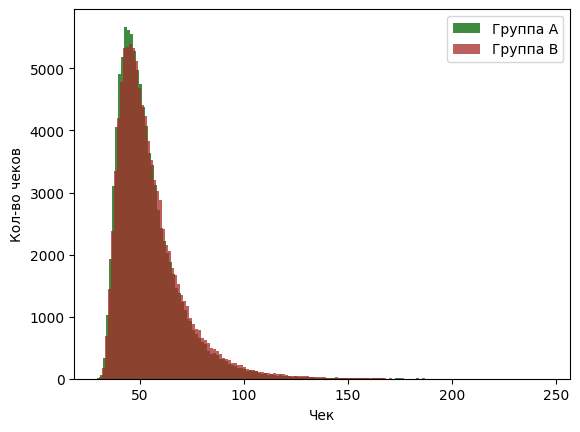

In [60]:
import matplotlib.pyplot as plt

np.random.seed(42)

n_obs = 100_000
d1 = np.random.lognormal(3, 0.6, n_obs) + np.random.normal(0, 1, n_obs) + np.array([30] * n_obs)
d2 = np.random.lognormal(3.05, 0.6, n_obs) + np.random.normal(0, 1, n_obs) + np.array([30] * n_obs)

d1 = d1[d1 < 250]
d2 = d2[d2 < 250]

plt.hist(d1, bins=150, alpha=0.75, label='Группа А', color='darkgreen')
plt.hist(d2, bins=150, alpha=0.75, label='Группа В', color='brown')
plt.xlabel('Чек')
plt.ylabel('Кол-во чеков')
plt.legend()
plt.show()